In [ ]:
import numpy as np
import pandas as pd 

In [ ]:
from scipy.io import loadmat

# List of patient id's that correspond to file names 

NoPainFiles = ['1004103_20070104_2Hz.mat','1008101_20061006_2Hz.mat','1026101_20070831_2Hz.mat',
            '1031101_20071102_2Hz.mat','2002101_20060708_2Hz.mat','2009101_20061028_2Hz.mat',
            '2017101_20061202_2Hz.mat','2023101_20070106_2Hz.mat','2026101_20070210_2Hz.mat',
            '2039102_20070811_2Hz.mat','2051101_20071201_2Hz.mat','2065101_20080927_2Hz.mat',
            '2111101_20100320_2Hz.mat','3008101_20070109_2Hz.mat','3021101_20070412_2Hz.mat',
            '3050101_20080114_2Hz.mat','3058101_20080314_2Hz.mat','3063101_20080629_2Hz.mat',
            '3071101_20090123_2Hz.mat','3073101_20090220_2Hz.mat']

PainFiles = ['1006101_20060915_2Hz.mat','1009101_20061013_2Hz.mat','1013101_20061201_2Hz.mat',
             '1019101_20070608_2Hz.mat','2003101_20060729_2Hz.mat','2006101_20060916_2Hz.mat',
             '2007101_20061014_2Hz.mat','2036101_20070616_2Hz.mat','2047101_20070922_2Hz.mat',
             '2055101_20080405_2Hz.mat','2057101_20080712_2Hz.mat','2066101_20081011_2Hz.mat',
             '2068101_20081129_2Hz.mat','2103101_20100123_2Hz.mat','2105101_20100116_2Hz.mat',
             '3007101_20070108_2Hz.mat','3026101_20070515_2Hz.mat','3029101_20080411_2Hz.mat',
             '3065101_20080727_2Hz.mat','3069101_20090118_2Hz.mat']

#Additive list of all files 

AllFiles = [*NoPainFiles, *PainFiles]

In [ ]:
def timeDiff(mat,time1,time2): 
    # function returns difference in two times (24hr clock) in 1/2 seconds 
    # str of var name (sleep_end and sleep_onset for example gives duration of sleep)
    # input is list entry, eg: ['05-Jan-2007 06:46:04']
    # for sleep start time to seconds 
    # time2 is later time

    startTime = mat[time1][0]
    startTime = startTime.split()[1]
    startTime = startTime.split(':')
    startTimeSecs = int(startTime[0])*3600 + int(startTime[1])*60 + int(startTime[2])
    # for sleep end time to seconds 
    endTime = mat[time2][0]
    endTime = endTime.split()[1]
    endTime = endTime.split(':')
    endTimeSecs = int(endTime[0])*3600 + int(endTime[1])*60 + int(endTime[2])

    Duration = endTimeSecs - startTimeSecs
    if Duration < 0:
        return (Duration + (24*3600))*2
    else:
        return Duration*2



def processedSignals(mat, signal): 
    # function to process RRI, PPGa, timerel
    # input a string that corresponds to variable name for dataset 
    # Could be 'timerel', 'RRI', or 'PPGa'

    rawSig = mat[signal]
    startTime = timeDiff(mat,'starttime','sleep_onset') #in 1/2 seconds, i.e index
    endTime = timeDiff(mat,'starttime','sleep_end') #in 1/2 seconds, i.e index
    processedSig = rawSig[startTime:endTime]

    return processedSig

def createDataFrames(mat):
    # processing time, making it start at 0 
    time = processedSignals(mat,'timerel')
    t = np.arange(0, 0.5*np.shape(time)[0], 0.5, dtype='float64')
    t = np.reshape(t,(np.shape(time)[0],1))

    # loading RRI/PPGa
    RRI = processedSignals(mat,'RRI')
    PPGa = processedSignals(mat,'PPGa')

    # dataframe of RRI and PPGa over time
    df = pd.DataFrame(np.hstack((t, RRI, PPGa)), columns = ['timerel', 'RRI', 'PPGa'])
    return df

def segment(df):
    # split dataframe into 5 minute signals 
    num_seconds = df.RRI.size / 2 
    num_5mins = int(num_seconds//300)
    split_data = np.array_split(df, num_5mins)
    # returned as a list
    return split_data

In [ ]:
df = createDataFrames(loadmat(PainFiles[7]))
df = df.interpolate()
df['PPGa'].isnull().values.any()

False

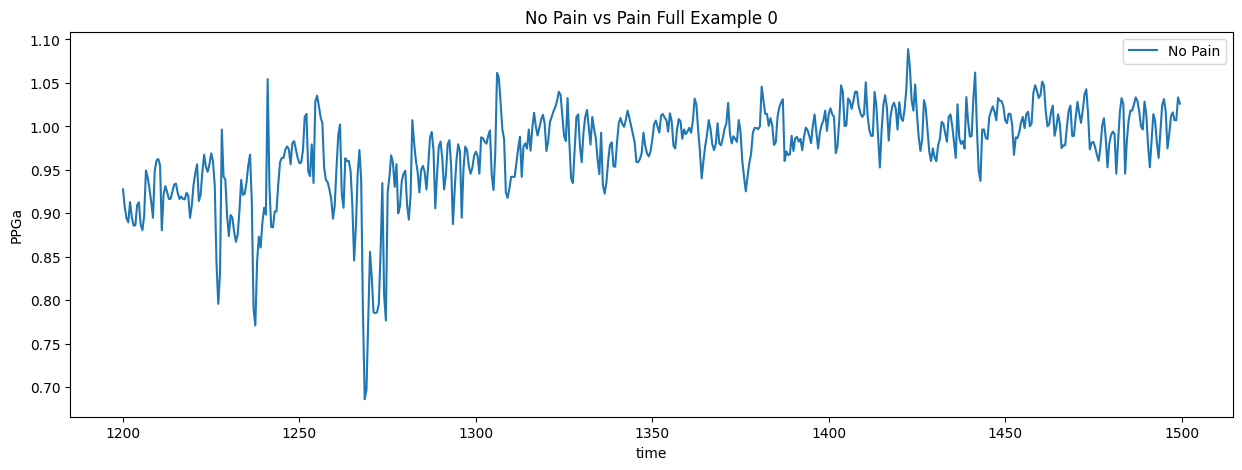

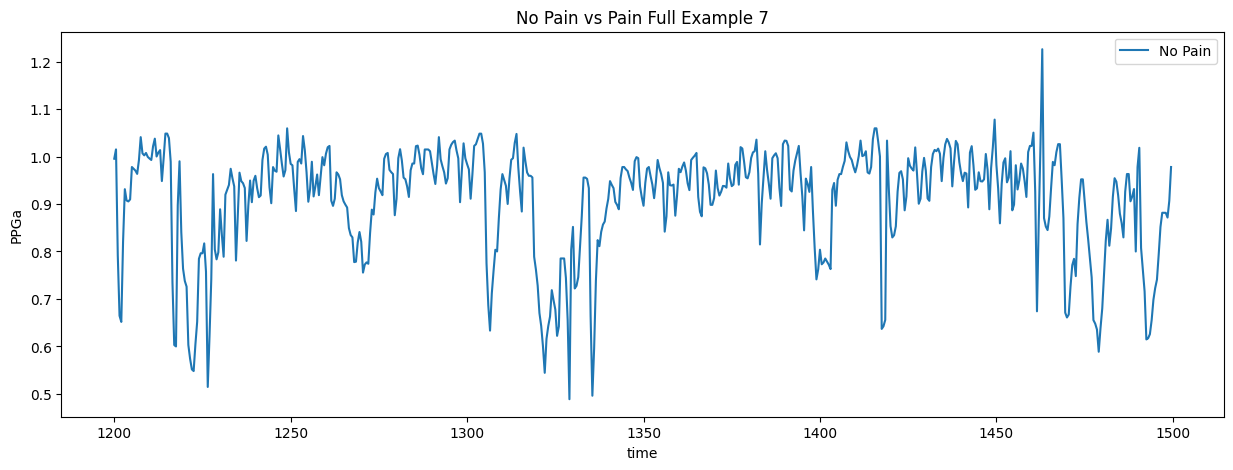

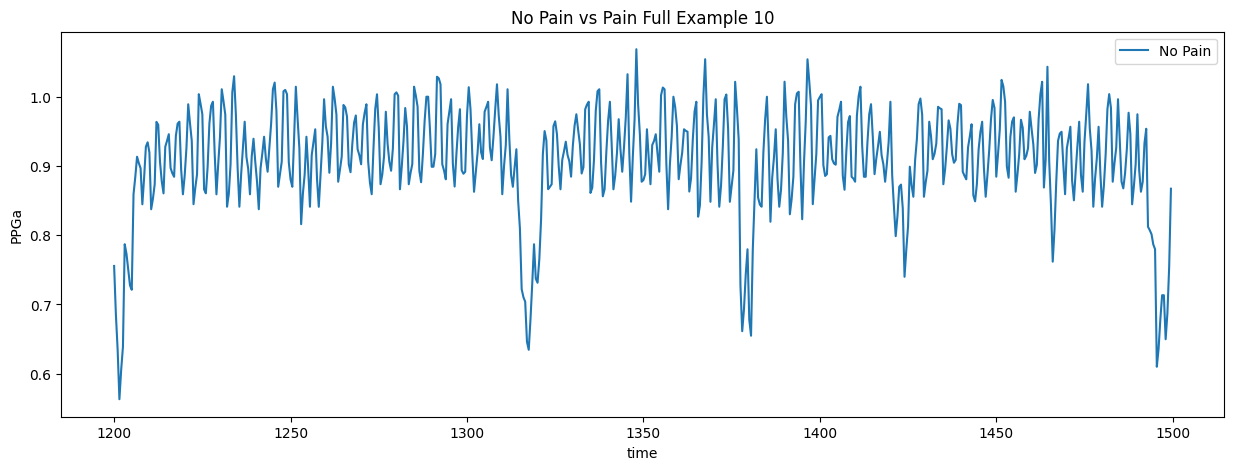

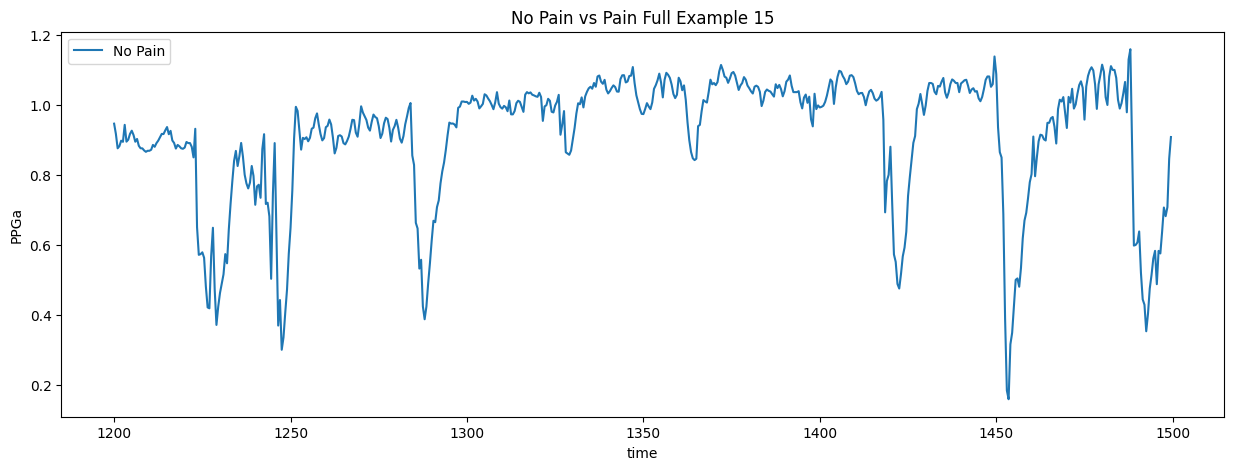

[1.16795451]


In [ ]:
import matplotlib.pyplot as plt


def plot(sample, five_mins = True):
    pain_file = loadmat(PainFiles[sample])
    PPG = processedSignals(pain_file,'PPGa')
    time = np.arange(0,len(PPG)/2, 0.5)
    time = time.reshape((len(PPG), 1))

    no_pain_file = loadmat(NoPainFiles[sample])
    PPG2 = processedSignals(no_pain_file,'PPGa')
    time2 = np.arange(0,len(PPG2)/2, 0.5)
    time2 = time2.reshape((len(PPG2), 1))

    plt.figure(figsize=(15,5))
    plt.title(f'No Pain vs Pain Full Example {sample}')
    plt.xlabel('time');plt.ylabel('PPGa')
    if five_mins == True:
        #plt.plot(time[2400:3000],PPG[2400:3000], label = 'Pain')
        plt.plot(time2[2400:3000],PPG2[2400:3000], label = 'No Pain')
        plt.legend()
        plt.show()
    else:
        #plt.plot(time,PPG, label = 'Pain')
        plt.plot(time2,PPG2, label = 'No Pain')
        plt.legend()
        plt.show()

#plot(0,False)
#plot(7,False)
#plot(10,False)
#plot(15,False)

plot(0)
plot(7)
plot(10)
plot(15)

print(max(processedSignals(loadmat(PainFiles[0]),'PPGa')))


In [ ]:
# code block to process all data

data = [] # initializing empty list to store data
#looping over all files
for i in range(len(AllFiles)):
    mat = loadmat(AllFiles[i])
    DF = createDataFrames(mat)
    split_data = segment(DF)
    #looping over 5 minute signals 
    for j in range(len(split_data)):
        x = pd.DataFrame(split_data[j])

        #need: clearance factor, RMS, 
        RRI_mean = x.RRI.mean()
        RRI_var = x.RRI.var()
        RRI_min = x.RRI.min()
        RRI_max = x.RRI.max()
        RRI_peak_to_peak = x.RRI.max() -x.RRI.min()
        RRI_kurt = x.RRI.kurtosis()
        RRI_skew = x.RRI.skew()
        

        #PPGa_mean = x.PPGa.mean() not meaningful
        PPGa_var = x.PPGa.var()
        PPGa_min = x.PPGa.min()
        PPGa_max = x.PPGa.max()
        PPGa_peak_to_peak = x.PPGa.max() -x.PPGa.min()
        PPGa_kurt = x.PPGa.kurtosis()
        PPGa_skew = x.PPGa.skew()

        
        

        #adding binary labels (1 for pain, 0 for no pain)
        if AllFiles[i] in PainFiles:
            row = [RRI_mean, RRI_var, RRI_min, RRI_max, RRI_peak_to_peak, RRI_kurt, RRI_skew, PPGa_var, PPGa_min, PPGa_max, PPGa_peak_to_peak, PPGa_kurt, PPGa_skew, PainFiles[i%20][:-8], 1]
        elif AllFiles[i] in NoPainFiles:
            row = [RRI_mean, RRI_var, RRI_min, RRI_max, RRI_peak_to_peak, RRI_kurt, RRI_skew, PPGa_var, PPGa_min, PPGa_max, PPGa_peak_to_peak, PPGa_kurt, PPGa_skew, NoPainFiles[i%20][:-8], 0]

        data.append(row)
    
df = pd.DataFrame(data, columns=['RRI_mean', 'RRI_var', 'RRI_min', 'RRI_max', 'RRI_peak_to_peak', 'RRI_kurt', 'RRI_skew', 'PPGa_var', 'PPGa_min', 'PPGa_max', 'PPGa_peak_to_peak', 'PPGa_kurt', 'PPGa_skew', 'Patient_id','Pain'])
df = df.interpolate()
    

In [ ]:
df.head(8)

,RRI_mean,RRI_var,RRI_min,RRI_max,RRI_peak_to_peak,RRI_kurt,RRI_skew,PPGa_var,PPGa_min,PPGa_max,PPGa_peak_to_peak,PPGa_kurt,PPGa_skew,Patient_id,Pain
0,624.469269,505.728688,540.0,774.0,234.0,5.837087,-0.575758,0.085506,0.142343,1.257336,1.114993,-1.364883,-0.496100,1004103_20070104,0
1,624.774751,421.472207,541.0,675.0,134.0,1.293346,-0.672395,0.009333,0.329682,0.985531,0.655849,7.148778,-2.561451,1004103_20070104,0
2,623.921761,149.398145,582.5,655.0,72.5,0.373591,-0.463120,0.001872,0.697498,1.054099,0.356600,3.808158,-1.071381,1004103_20070104,0
3,633.473920,587.633978,515.2,695.0,179.8,4.196881,-1.221828,0.037200,0.213155,1.255113,1.041958,1.443306,-1.306326,1004103_20070104,0
4,635.108970,146.580718,605.0,670.0,65.0,-0.405681,0.022396,0.002644,0.686183,1.088763,0.402580,4.826742,-1.689985,1004103_20070104,0
5,632.861130,122.179019,590.0,665.0,75.0,0.325169,-0.201358,0.000765,0.906915,1.064490,0.157574,0.180722,-0.427407,1004103_20070104,0
6,635.131229,137.129972,596.8,662.6,65.8,0.053486,-0.346911,0.001174,0.825953,1.057877,0.231924,1.905243,-0.935894,1004103_20070104,0
7,627.228738,156.986511,590.0,660.0,70.0,-0.215239,-0.277028,0.000844,0.896024,1.061528,0.165504,0.242258,-0.364388,1004103_20070104,0


In [ ]:
print(df.describe())

          RRI_mean        RRI_var      RRI_min      RRI_max  RRI_peak_to_peak  \
count  3910.000000    3910.000000  3910.000000  3910.000000       3910.000000   
mean    744.639554    4791.025513   607.545691   927.008338        319.462647   
std     117.382105    7700.516055    91.944344   188.093615        167.694397   
min     397.500000       0.000000   250.000000   397.500000          0.000000   
25%     652.019889     913.647796   545.000000   785.000000        197.300000   
50%     732.531024    2119.012780   600.000000   905.000000        284.550000   
75%     813.049844    5143.781114   662.950000  1040.000000        400.000000   
max    1183.412375  130331.565031   930.000000  1510.000000       1137.500000   

          RRI_kurt     RRI_skew     PPGa_var     PPGa_min     PPGa_max  \
count  3910.000000  3910.000000  3910.000000  3910.000000  3910.000000   
mean      1.267430     0.295252     0.016359     0.348971     1.053319   
std       2.913100     0.776873     0.012208    

In [ ]:
shuffled_df = df.sample(frac=1)

shuffled_df.head()

# first normalize each complete time series 

,RRI_mean,RRI_var,RRI_min,RRI_max,RRI_peak_to_peak,RRI_kurt,RRI_skew,PPGa_var,PPGa_min,PPGa_max,PPGa_peak_to_peak,PPGa_kurt,PPGa_skew,Patient_id,Pain
377,774.514511,27048.386571,555.0,1300.0,745.0,0.514424,1.171850,0.017145,0.233581,0.993856,0.760276,0.253697,-0.235143,1031101_20071102,0
2233,962.659468,21100.948005,660.8,1340.0,679.2,-0.358345,0.397624,0.014890,0.520666,1.152838,0.632171,0.122150,-0.756854,1013101_20061201,1
2185,723.899171,3999.318388,516.7,890.0,373.3,1.847101,-0.767029,0.012112,0.517127,1.068507,0.551380,0.996435,-1.182269,1009101_20061013,1
2804,892.524293,1809.657542,738.6,1010.0,271.4,0.680014,-0.507351,0.014645,0.291992,1.104870,0.812878,3.207872,-1.776070,2047101_20070922,1
2823,909.281198,1140.367329,824.8,1020.0,195.2,-0.032920,0.161994,0.007955,0.350710,0.865639,0.514929,4.075203,-2.070639,2047101_20070922,1


Logistic Regression

In [ ]:
# Importing the dataset
X = shuffled_df.iloc[:, [0, 1, 2, 3, 4, 5, 6]].values
y = shuffled_df.iloc[:, -2].values

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import plot_confusion_matrix

print(f'Score = {classifier.score(X_test, y_test) * 100}')

plot_confusion_matrix(classifier, X_test, y_test)  
plt.show()

KNN

In [ ]:
# Importing the dataset
X = shuffled_df.iloc[:, [0, 1, 2, 3, 4, 5, 6]].values
y = shuffled_df.iloc[:, -2].values

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting K-NN to the Training set
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Accuracy
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")

# Making the Confusion Matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(classifier, X_test, y_test)  
plt.show()

Decision Tree

In [ ]:
# Importing the dataset
X = shuffled_df.iloc[:, [0, 1, 2, 3, 4, 5, 6]].values
y = shuffled_df.iloc[:, -2].values

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Decision Tree Classification to the Training set
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Accuracy
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")

# Making the Confusion Matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(classifier, X_test, y_test)  
plt.show()

Random Forest

Accuracy Score: 0.8384458077709611 with n_estimators: 63


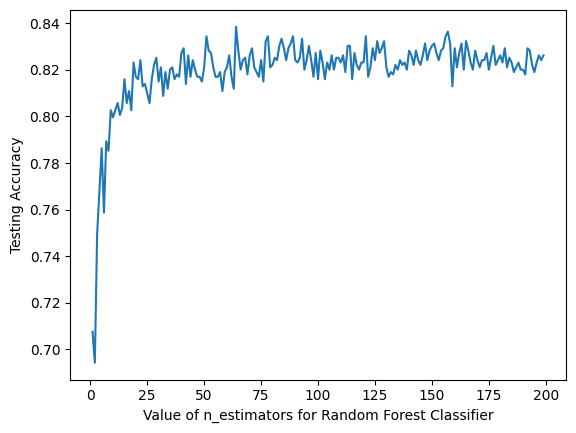

In [ ]:
# Importing the dataset
X = shuffled_df.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]].values
y = shuffled_df.iloc[:, -1].values

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
scores =[]
for k in range(1, 200):
    rfc = RandomForestClassifier(n_estimators=k)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

import matplotlib.pyplot as plt
%matplotlib inline

# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(range(1, 200), scores)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('Testing Accuracy')

maxs = max(scores)
maxs_idx = scores.index(maxs)

print(f"Accuracy Score: {maxs} with n_estimators: {maxs_idx}")


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


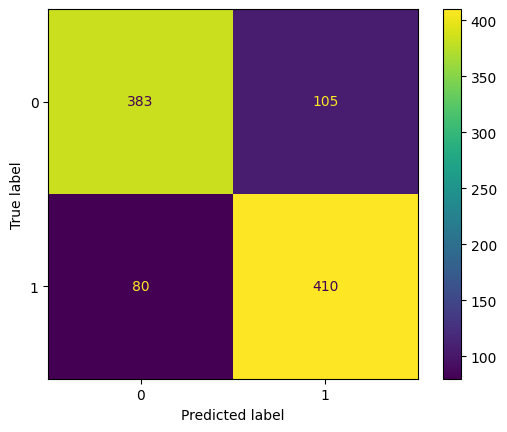

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = maxs_idx, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)


# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(classifier, X_test, y_test)  
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance

importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)



result = permutation_importance(
    classifier, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

feature_names = shuffled_df.columns.to_list()[0:-2]

forest_importances = pd.Series(result.importances_mean, index=feature_names)

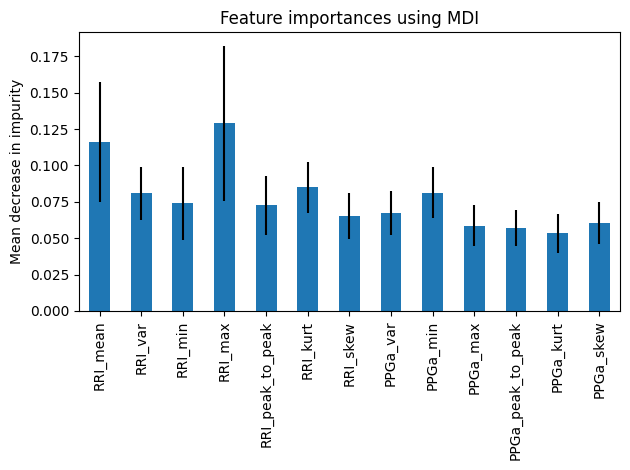

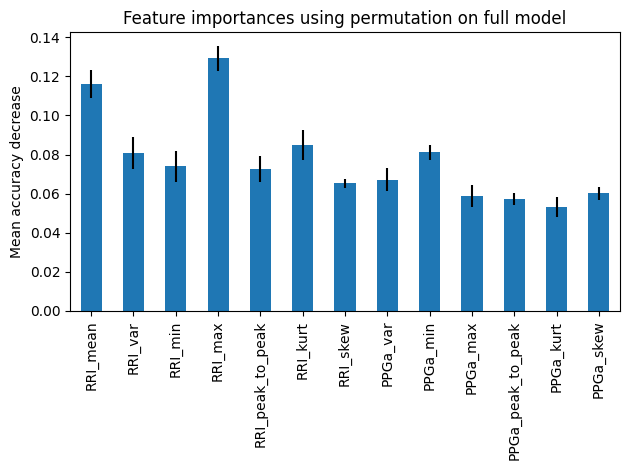

In [ ]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()